# 情報システム工学演習 課題提出用ファイル

本ファイルに実装し、`{学籍番号}.ipynb`にリネームの上、必要な入力データ（あれば）とあわせて`{学籍番号}.zip`にまとめること。

この際、`{学籍番号}.ipynb`を実行したらそのまま読み込める場所に入力データを配置しておくことが望ましい（それが難しい場合はどこかにその旨記載しておくこと）。
レポートをコンパイルしたもの（`{学籍番号}.pdf`）と合わせてCLEから提出すること。

ちなみに：`.ipynb`は嫌！という方はまずは一度ご相談ください。Python、C++、Javaなど、いろいろ対応できます。

---
## 課題情報

### 提出者

学籍番号：08D20091

氏名：Do Thai Don

### 概要

実装したアプリ・システム・ツールの概要・アピールポイント：
- 演習課題の中級編と異なるアプローチ
- 画像から本のカバーを検出
- 検出過程で使われるフィルタの設定値を変更したり格納したりすることができる


---
## 本アプリ

In [1]:
# ライブラリ類の読み込み
import cv2
import numpy as np  # PythonのOpenCVでは、画像はnumpyのarrayとして管理される
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

# 画像表示用の関数（jupyter notebookでインラインで表示したい時向け）
def imshow_inline(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # OpenCVの画像は、BGRの順に色が並んでいるので
        display(Image.fromarray(img))
    else:
        display(Image.fromarray(img))

In [74]:
#######################################
# utils
#######################################

def adjust_contrast_brightness(img, contrast:float=1.0, brightness:int=0):
    ## adjust contrast and brightness for better edge detection
    ## https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    """
    Adjusts contrast and brightness of an uint8 image.
    contrast:   (0.0,  inf) with 1.0 leaving the contrast as is
    brightness: [-255, 255] with 0 leaving the brightness as is
    """
    brightness += int(round(255*(1-contrast)/2))
    return cv2.addWeighted(img, contrast, img, 0, brightness)

## trackbars
# 引用：https://www.computervision.zone/lessons/code-files-7/
def nothing(x):
    pass

def initializeTrackbars(windowName, intialTracbarVals=0):
    cv2.namedWindow(windowName)
    cv2.createTrackbar("Contrast", windowName, 100, 1000, nothing)
    cv2.createTrackbar("Brightness", windowName, 255, 510, nothing)
    cv2.createTrackbar("Blur kernel size", windowName, 2, 12, nothing)
    cv2.createTrackbar("Blur sigmaX", windowName, 5, 10, nothing)
    cv2.createTrackbar("Canny thres1", windowName, 10, 255, nothing)
    cv2.createTrackbar("Canny thres2", windowName, 200, 255, nothing)
 
 
def valTrackbars(windowName):
    Contrast = cv2.getTrackbarPos("Contrast",windowName)
    Brightness = cv2.getTrackbarPos("Brightness", windowName)
    BlurKSize = cv2.getTrackbarPos("Blur kernel size", windowName)
    BlurSigma = cv2.getTrackbarPos("Blur sigmaX", windowName)    
    Threshold1 = cv2.getTrackbarPos("Canny thres1",windowName)
    Threshold2 = cv2.getTrackbarPos("Canny thres2", windowName)
    src = Contrast, Brightness, BlurKSize, BlurSigma, Threshold1,Threshold2
    return src

## perspective transform
def reorder(myPoints):
    # 引用：https://www.computervision.zone/lessons/code-files-7/
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
 
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
 
    return myPointsNew

def perspectiveTransfrom(img, pts_ref):
    w = 400
    h = 600
    pts_ref = reorder(pts_ref)
    pts_dst = np.float32([[0,0], [w,0], [0,h], [w,h]])
    H, mask = cv2.findHomography(pts_dst, pts_ref, cv2.RANSAC, 3.0)
    H_inv = np.linalg.inv(H)
    dst = cv2.warpPerspective(img, H_inv, (w,h), flags=cv2.INTER_NEAREST) 
    sharpen_filter = np.array([[0, -1, 0], [-1, 9, -1], [0, -1, 0]])
    sharped_img = cv2.filter2D(dst, -1, sharpen_filter)
    return dst

### 本番の処理

settings = [512, 195, 3, 7, 115, 88]


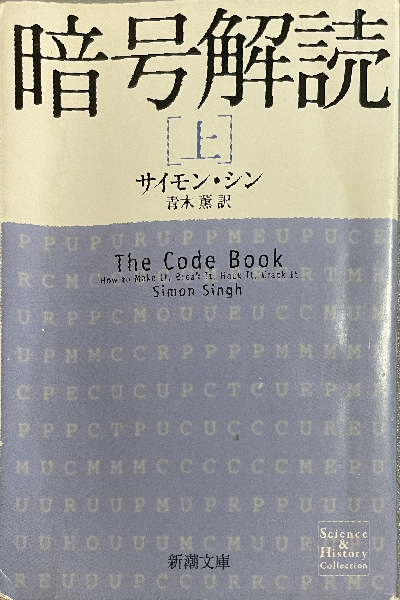

In [75]:
#######################################
# Detect book/paper corners
# Input: image
# Output: trackbar settings, book cover/paper image
#######################################

# load the image
fileName = '5.JPG'
src = cv2.imread("input/" + fileName)

# resize for better performance
height, width, channels =  src.shape
resized = cv2.resize(src, (width//3, height//3))

# initiate windows
initializeTrackbars("App")
# cv2.namedWindow("App")

# result value
settings = []
corners = []

# start app
while True:
    # read value from trackbars
    contrast, brightness, blurKSize, blurSigma, thres1, thres2 = valTrackbars("App")
    contrast = contrast / 100 # Contrast is in range [0, inf]. 1.0 is default
    brightness = brightness - 255 # Brightness is in range [-255, 255]. 0 is default
    blurKSize = blurKSize*2 + 1 # only get odd value
    
    # apply filter
    calibrated = adjust_contrast_brightness(resized, contrast, brightness) # Calibration
    gray = cv2.cvtColor(calibrated, cv2.COLOR_BGR2GRAY) # Gray scale
    blurred = cv2.GaussianBlur(gray,ksize=(blurKSize,blurKSize),sigmaX=blurSigma) # Blur
    
    # edge detection
    edged = cv2.Canny(blurred,thres1,thres2) # canny edge
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel) # close gap between white pixel on edges
    
    # contour detection
    contours, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    draw = resized.copy()
    curCorners = []
    maxArea = 0.0
    
    for contour in contours:
        # approximate the contour
        # https://pystyle.info/opencv-structural-analysis-and-shape-descriptors/#outline__16
        arcLen = cv2.arcLength(contour, True)
        approxCurve = cv2.approxPolyDP(contour, 0.02 * arcLen, True)
        
        # if the approximated contour has four points, then assume that the
        # contour is a book -- a book is a rectangle and thus has four vertices
        if len(approxCurve) == 4:
            area = cv2.contourArea(approxCurve)
            if area > maxArea:
                curCorners = approxCurve
                
    if len(curCorners) == 4:
        cv2.drawContours(draw, [curCorners], -1, (0, 255, 0), 4)
        
        
    # display the output
    h,w = resized.shape[0], resized.shape[1]
    out = np.zeros((h*2,w*3, 3), np.uint8)
    out[0:h, 0:w, :]  = calibrated
    out[0:h, w:w*2, :] = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) 
    out[0:h, w*2:w*3, :] = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)
    out[h:h*2, 0:w, :] = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)
    out[h:h*2, w:w*2, :] = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
    out[h:h*2, w*2:w*3, :] = draw
    
    cv2.putText(out,
        text='CALIBRATION',
        org=(10, 60),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.putText(out,
        text='GRAYSCALE',
        org=(10+w, 60),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.putText(out,
        text='BLUR',
        org=(10+w*2, 60),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.putText(out,
        text='CANNY EDGE',
        org=(10, 60+h),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.putText(out,
        text='GAP CLOSED',
        org=(10+w, 60+h),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.putText(out,
        text='CONTOUR DETECTION',
        org=(10+w*2, 60+h),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.0,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA)
    cv2.imshow("App", out)
    

    
    # close window
    key = cv2.waitKey(60)
    if key == ord('s'): # save settings and corners     
        settings = (contrast, brightness, blurKSize, blurSigma, thres1, thres2)
        corners = curCorners
        break
        
    if key == 27 or key == ord('q'):  # qかESCが押されたら途中で終了
        break
        
# quit app
cv2.destroyAllWindows()
for i in range (1,5):
    cv2.waitKey(1)

# ouput
if len(settings) != 0:
    settingFile = open('output/settings.txt', "w") # save settings into text file
    settings = list(settings)
    settings[0] = int(settings[0]*100)
    settings[1] = settings[1]+255
    settings[2] = int((settings[2]-1)/2)
    line = str(settings)
    settingFile.write(line)
    settingFile.close()
    
    print("settings = {}".format(settings))

if len(corners) == 4:
    out = resized.copy() # output image
    out = perspectiveTransfrom(resized, corners)
    cv2.imwrite('output/'+fileName, out)
    imshow_inline(out)
